In [133]:
%load_ext autoreload
%autoreload 2


import config
from tools import dataloader, preprocess
from tools import dataloader_tools as data_loader

import os
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import PIL.Image as Image
from torch import nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import torch
from torchvision import transforms, utils, datasets
from IPython import display

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)

import pandas as pd
import open3d as o3d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda:2


In [134]:
#sk_data_path = "/home/vglasov/datasets/L_CAS_3D_Point_Cloud_People_Dataset/3D Point Cloud People Dataset/LCAS_20160523_1227_1238_pcd/"
sk_data_path = "/home/vglasov/main1/"
paths = [sk_data_path + s for s in os.listdir(sk_data_path)]
paths = sorted(paths)

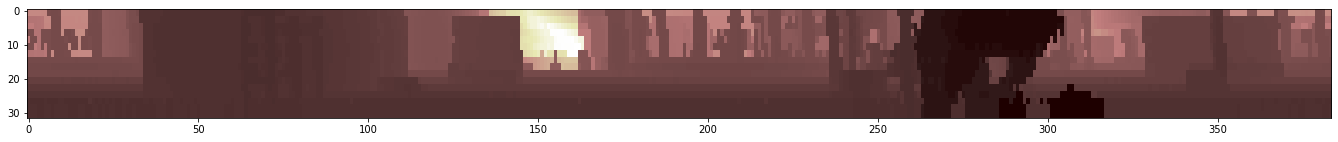

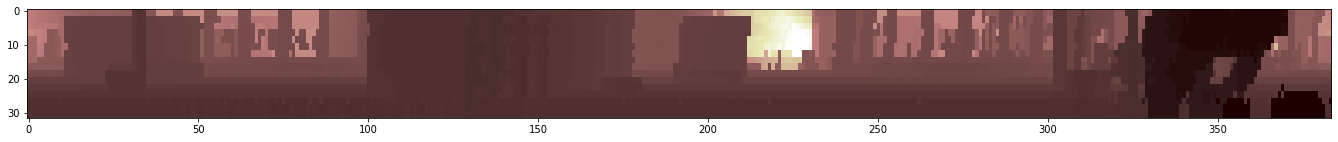

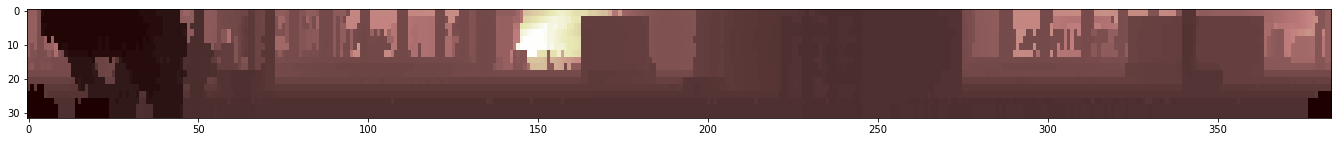

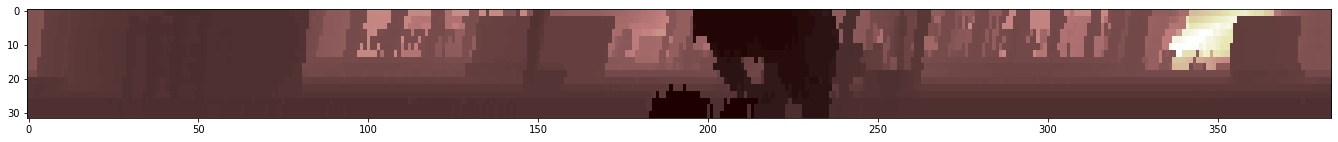

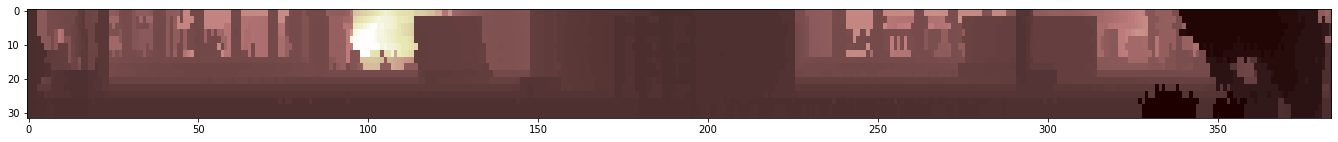

In [135]:
aug_dict = {'rotate': True,
            'flip': True,
            'slanting': True,
            'shuffling': True}

def show_pcd(path):
    pcd = o3d.io.read_point_cloud(path)
    pcd2img = preprocess.Pcd2ImageTransform(augmentation=aug_dict).fit(pcd, [])
    data = pcd2img.transform()

    X = data_loader.interp_data(data, data[:,:,3] != 0)[:, :, 3]
#     X = data[:, :, 3]
    plt.figure(figsize=(24, 2))
    plt.imshow(np.repeat(X[:, :], 2, axis=0), cmap='pink')
    plt.show()

for i in range(5):
    show_pcd(paths[1])

In [92]:
from model import Unet as models

MODEL_PATH = "UNet_best.pth"

model = models.ResNetUNet(1).to(device)
if torch.cuda.is_available():
    model.to(device)
    model.load_state_dict(torch.load(MODEL_PATH))
else:
    model.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))

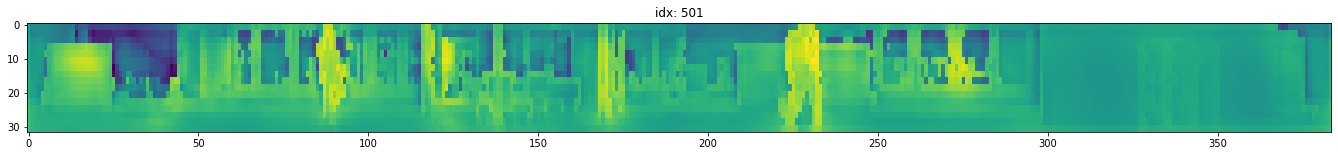

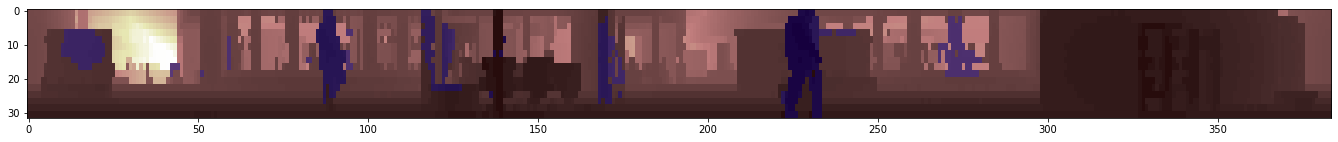

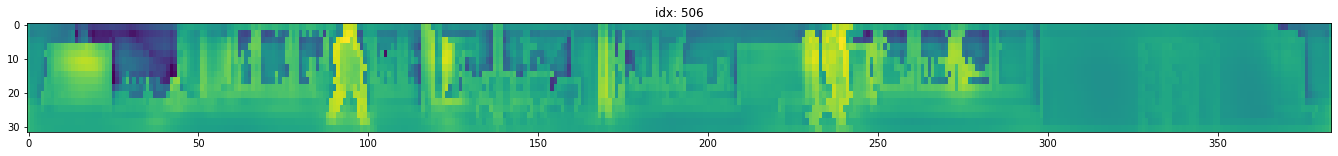

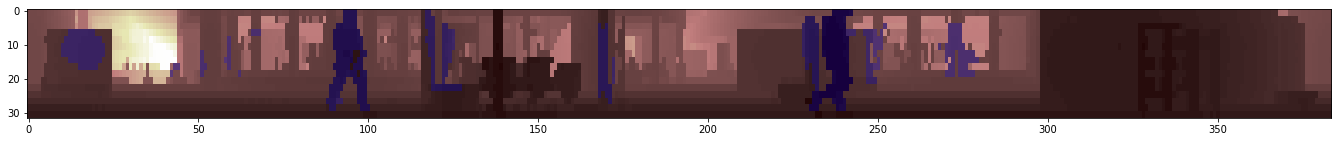

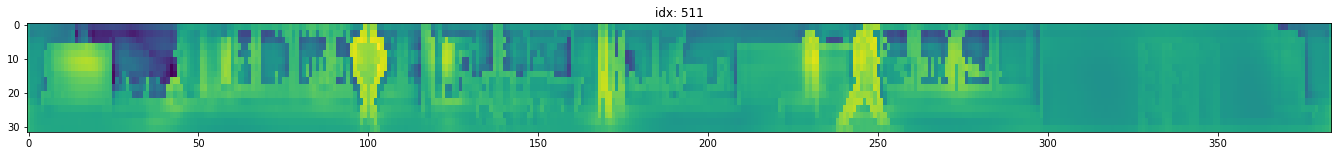

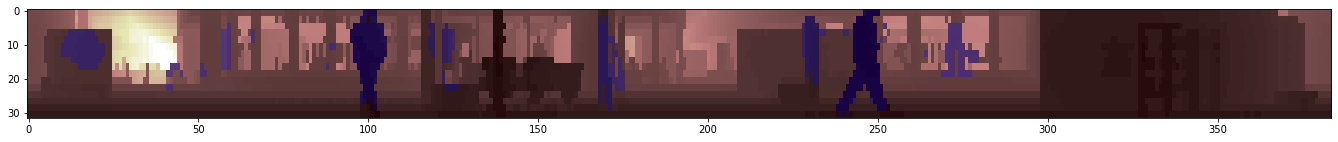

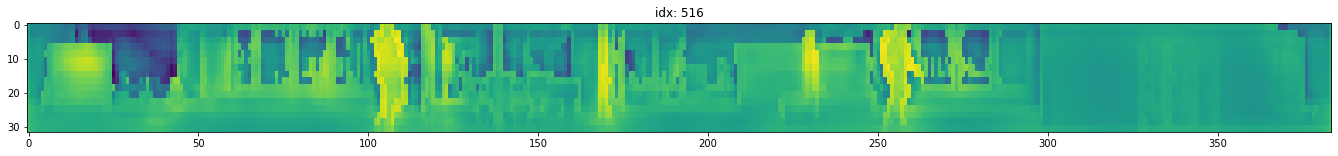

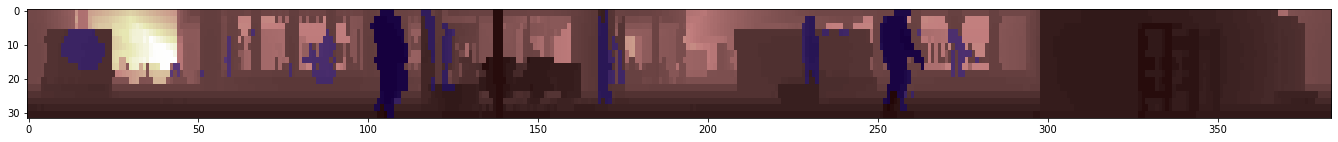

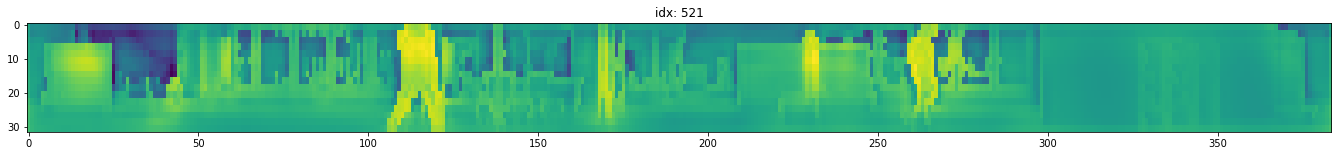

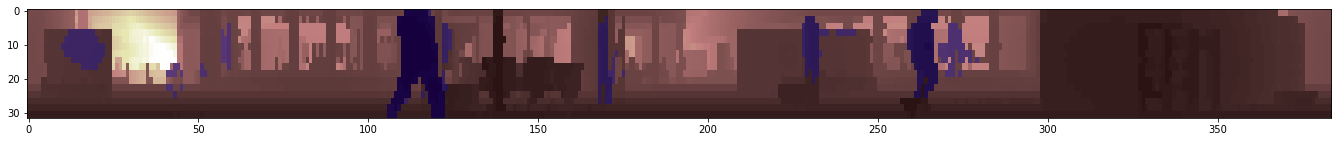

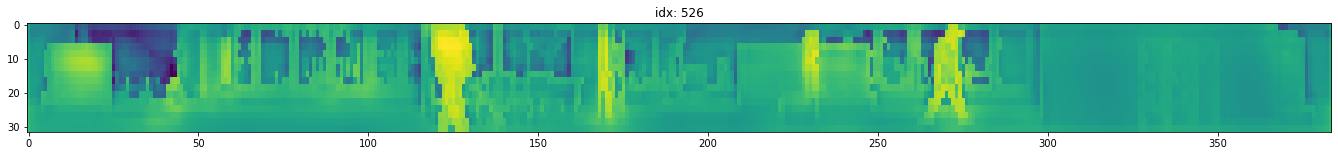

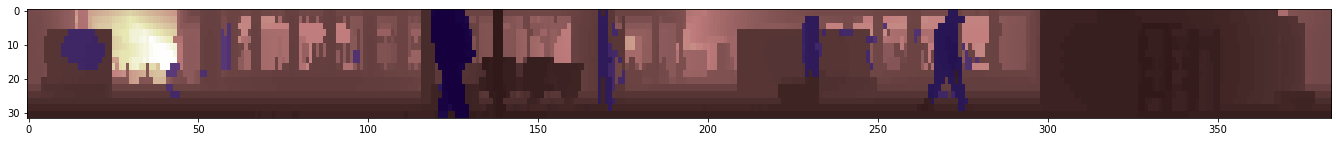

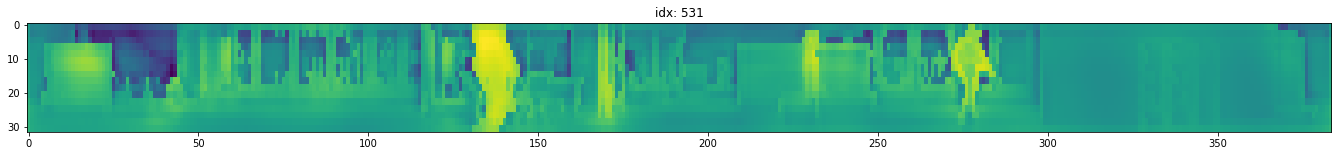

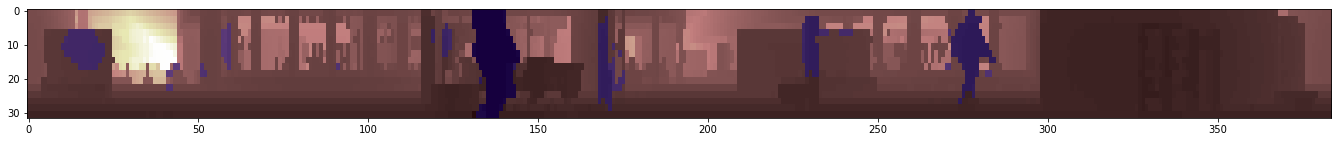

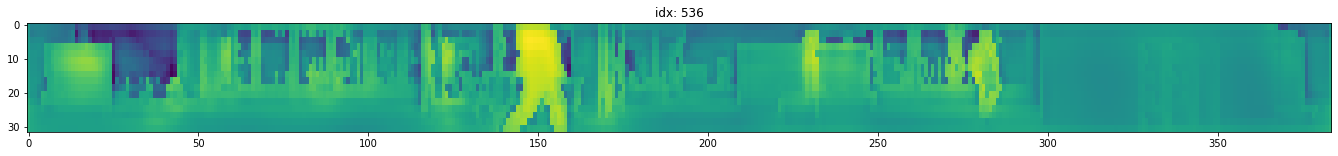

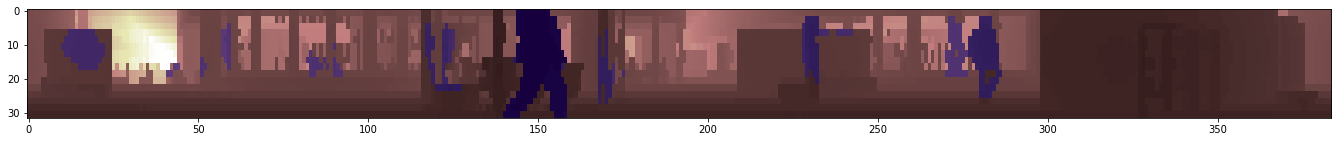

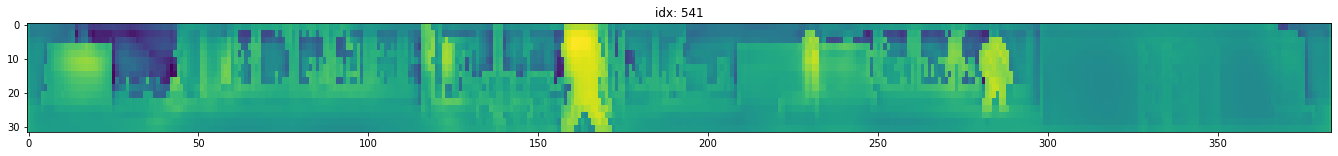

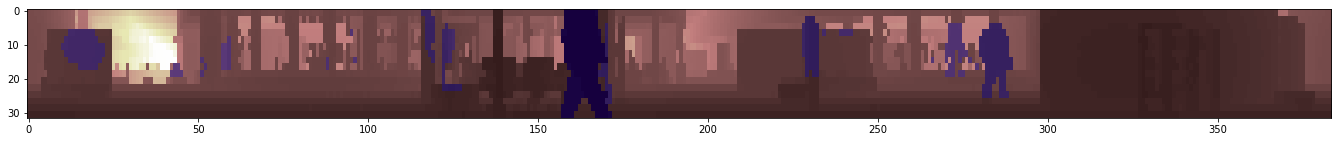

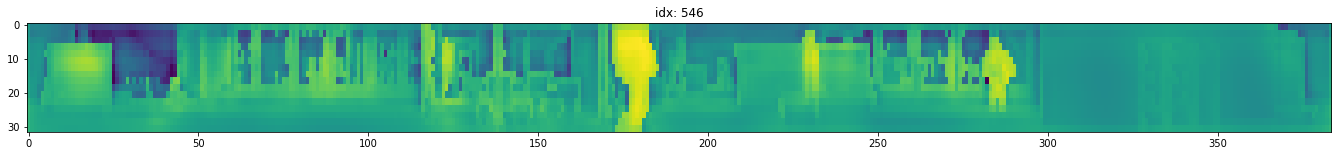

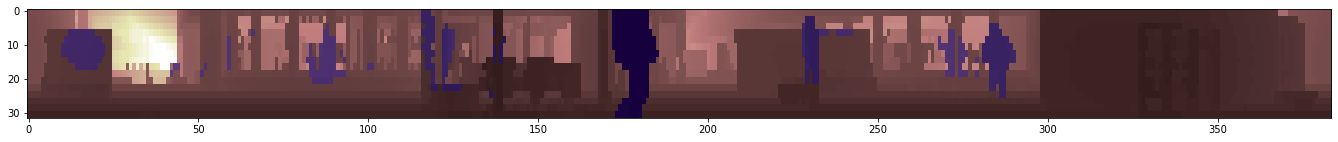

In [150]:
model.eval()
for idx, path in enumerate(paths[501:550:5]):
    pcd = o3d.io.read_point_cloud(path)
    pcd2img = preprocess.Pcd2ImageTransform().fit(pcd, [])
    data = pcd2img.transform()

#     mask = data[:,:,0] != 0
    data = data_loader.interp_data(data, data[:,:,3] != 0)
    p, n = data_loader.pointnetize(data[:,:,0:4], n_size=[3,3])
#     groundtruth = data_loader.apply_mask(data[:,:,-1], mask)

    p = torch.tensor(p, dtype=torch.float).permute(-1, -2, 0, 1).to(device)
    n = torch.tensor(n, dtype=torch.float).permute(-1, -2, 0, 1).to(device)
    
    pred = model(p[None, 0:4, ...], n[None, 0:3, ...])
    plt.figure(figsize=(24, 2))
    plt.title("idx: %d" % (5 * idx + 501))
#     plt.imshow(np.repeat(p.cpu().detach()[-1, 0, :, :], 2, axis=0), cmap='pink')
    plt.imshow(np.repeat(pred.cpu().detach()[0, 0, :, :], 2, axis=0))
#     plt.imshow(np.repeat(label.cpu().detach()[0, :, :], 2, axis=0), cmap=ListedColormap([[0., 0., 0., 0.], [0., 1., 0., 0.2]]))
    plt.show()
    plt.figure(figsize=(24, 2))
    plt.imshow(np.repeat(p.cpu().detach()[-1, 0, :, :], 2, axis=0), cmap='pink')
    plt.imshow(np.repeat(pred.cpu().detach()[0, 0, :, :], 2, axis=0) > 0, cmap=ListedColormap([[0., 0., 0., 0.], [0., 0., 1., 0.25]]))
#     plt.imshow(np.repeat(label.cpu().detach()[0, :, :], 2, axis=0), cmap=ListedColormap([[0., 0., 0., 0.], [0., 1., 0., 0.2]]))
    plt.show()

In [145]:
from model import Unet as models

MODEL_PATH = "UNet_xyz_r.pth"

model = models.ResNetUNet(1).to(device)
if torch.cuda.is_available():
    model.to(device)
    model.load_state_dict(torch.load(MODEL_PATH))
else:
    model.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))
    
model.eval()
pcd = o3d.io.read_point_cloud(paths[511])
pcd2img = preprocess.Pcd2ImageTransform().fit(pcd, [])
data = pcd2img.transform()

#     mask = data[:,:,0] != 0
data = data_loader.interp_data(data, data[:,:,3] != 0)
p, n = data_loader.pointnetize(data[:,:,0:4], n_size=[3,3])
#     groundtruth = data_loader.apply_mask(data[:,:,-1], mask)

p = torch.tensor(p, dtype=torch.float).permute(-1, -2, 0, 1).to(device)
n = torch.tensor(n, dtype=torch.float).permute(-1, -2, 0, 1).to(device)

pred = model(p[None, 0:4, ...], n[None, 0:3, ...])

pcd_labeled = pcd2img.inverse_transform(pred.detach().cpu().numpy()[0, 0, :, :] > 0)
o3d.io.write_point_cloud("data/pcd_labeled_2.pcd", pcd_labeled)

In [119]:
intrinsic = o3d.camera.PinholeCameraIntrinsic(384, 16, np.pi, 0.5236 / 2, 384 // 2, 16 // 2)
o3d.geometry.PointCloud.create_from_depth_image(data[:,:,3].T, intrinsic)

TypeError: create_from_depth_image(): incompatible function arguments. The following argument types are supported:
    1. (depth: open3d::geometry::Image, intrinsic: open3d.open3d.camera.PinholeCameraIntrinsic, extrinsic: numpy.ndarray[float64[4, 4]] = array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), depth_scale: float = 1000.0, depth_trunc: float = 1000.0, stride: int = 1) -> open3d.open3d.geometry.PointCloud

Invoked with: array([[8.7700002 , 8.72800155, 8.64000001, ..., 4.61200006, 3.94200012,
        3.44000005],
       [8.78999988, 8.7320005 , 8.66399957, ..., 4.61199984, 3.9420003 ,
        3.44000014],
       [8.85600081, 8.78000042, 8.70000082, ..., 4.6160003 , 3.94800006,
        3.43800031],
       ...,
       [8.8780004 , 8.79200135, 8.72399915, ..., 4.60800017, 3.91600002,
        3.42800018],
       [8.80599993, 8.74200063, 8.6640003 , ..., 4.60999988, 3.93200023,
        3.43200012],
       [8.77800151, 8.72400027, 8.63600046, ..., 4.61000028, 3.93200009,
        3.43599987]]), camera::PinholeCameraIntrinsic with width = 384 and height = 16.
Access intrinsics with intrinsic_matrix.

In [121]:
o

0.5160000739389239

In [122]:
import numpy as np
import open3d as o3
from open3d import JVisualizer

fragment = o3.io.read_point_cloud(paths[1])
visualizer = JVisualizer()
visualizer.add_geometry(fragment)
visualizer.show()

JVisualizer with 1 geometries

In [127]:
def custom_draw_geometry(pcd):
    # The following code achieves the same effect as:
    # o3d.visualization.draw_geometries([pcd])
    vis = o3d.visualization.Visualizer()
    vis.create_window()
#     vis.add_geometry(pcd)
    vis.run()
    vis.destroy_window()

In [128]:
custom_draw_geometry(None)

RuntimeError: [1;31m[Open3D ERROR] GLFW Error: X11: The DISPLAY environment variable is missing[0;m

In [129]:
# examples/Python/Basic/visualization.py

import numpy as np
import open3d as o3d

if __name__ == "__main__":

    print("Load a ply point cloud, print it, and render it")
    pcd = o3d.io.read_point_cloud("../../TestData/fragment.ply")
    o3d.visualization.draw_geometries([pcd])

    print("Let's draw some primitives")
    mesh_box = o3d.geometry.TriangleMesh.create_box(width=1.0,
                                                    height=1.0,
                                                    depth=1.0)
    mesh_box.compute_vertex_normals()
    mesh_box.paint_uniform_color([0.9, 0.1, 0.1])
    mesh_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=1.0)
    mesh_sphere.compute_vertex_normals()
    mesh_sphere.paint_uniform_color([0.1, 0.1, 0.7])
    mesh_cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=0.3,
                                                              height=4.0)
    mesh_cylinder.compute_vertex_normals()
    mesh_cylinder.paint_uniform_color([0.1, 0.9, 0.1])
    mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=0.6, origin=[-2, -2, -2])

    print("We draw a few primitives using collection.")
    o3d.visualization.draw_geometries(
        [mesh_box, mesh_sphere, mesh_cylinder, mesh_frame])

    print("We draw a few primitives using + operator of mesh.")
    o3d.visualization.draw_geometries(
        [mesh_box + mesh_sphere + mesh_cylinder + mesh_frame])

    print("Let's draw a cubic using o3d.geometry.LineSet.")
    points = [
        [0, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [1, 1, 0],
        [0, 0, 1],
        [1, 0, 1],
        [0, 1, 1],
        [1, 1, 1],
    ]
    lines = [
        [0, 1],
        [0, 2],
        [1, 3],
        [2, 3],
        [4, 5],
        [4, 6],
        [5, 7],
        [6, 7],
        [0, 4],
        [1, 5],
        [2, 6],
        [3, 7],
    ]
    colors = [[1, 0, 0] for i in range(len(lines))]
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector(lines),
    )
    line_set.colors = o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([line_set])

    print("Let's draw a textured triangle mesh from obj file.")
    textured_mesh = o3d.io.read_triangle_mesh("../../TestData/crate/crate.obj")
    textured_mesh.compute_vertex_normals()
    o3d.visualization.draw_geometries([textured_mesh])

Load a ply point cloud, print it, and render it


RuntimeError: [1;31m[Open3D ERROR] GLFW Error: X11: The DISPLAY environment variable is missing[0;m

In [131]:
import numpy as np
import open3d as o3
from open3d import JVisualizer

fragment = o3.geometry.PointCloud(o3d.utility.Vector3dVector(np.random.rand(100, 3)))
visualizer = JVisualizer()
visualizer.add_geometry(fragment)
visualizer.show()

JVisualizer with 1 geometries